# Training a CNN

Used this blog as a starting point:

http://blog.christianperone.com/2015/08/convolutional-neural-networks-and-feature-extraction-with-python/

Another good one:

http://nbviewer.jupyter.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb

And this one:

https://colinpriest.com/category/convolutional-neural-networks/


# Lots of imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm     as cm
import matplotlib.image  as mpimg
%matplotlib inline  

from urllib import urlretrieve

import cPickle as pickle
import os
import gc
import gzip
import numpy as np
import theano
import lasagne

from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.updates import adam

from lasagne.nonlinearities import softmax
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize
from nolearn.lasagne import PrintLayerInfo
from nolearn.lasagne import BatchIterator

from nolearn.lasagne.visualize import draw_to_notebook
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
from nolearn.lasagne.visualize import plot_saliency

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

layer_info = PrintLayerInfo()

Using cuDNN version 5005 on context None
Mapped name None to device cuda: GeForce GTX 680 (0000:05:00.0)
Using cuDNN version 5005 on context dev0
Mapped name dev0 to device cuda0: GeForce GTX 680 (0000:05:00.0)
Using cuDNN version 5005 on context dev1
Mapped name dev1 to device cuda1: GeForce GTX 680 (0000:04:00.0)
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Define our dataset loading function

The dataset is just a set of images stored in a shallow tree, with the directory signifying the class of the image. The images should all be normalized, using the code in the 'Image normalization' workbook.

In [2]:
def load_dataset(base_path):
    X            = []
    y            = []
    class_labels = {}
    
    for subdir, dirs, files in os.walk(base_path):
        for file in files:
            file_path  = os.path.join(subdir, file)
            image      = mpimg.imread(file_path)
            class_name = os.path.dirname(file_path).replace(base_path, '', 1)
            
            if not class_name in class_labels:
                class_labels[class_name] = len(class_labels)
                
            X.append(np.asarray(image))
            y.append(class_labels[class_name])
    
    class_labels_inverted = {v: k for k, v in class_labels.iteritems()}

    X = np.array(X).transpose((0,3,1,2))
    y = np.array(y)
    return X, y, class_labels_inverted

In [3]:
def split_dataset(X, y):
    indices = np.random.permutation(len(y))
    training_idx, test_idx = indices[:int(len(y) * 0.8)], indices[int(len(y) * 0.8):]
    
    X_train, y_train = X[training_idx], y[training_idx].astype(np.int32)
    X_test,  y_test  = X[test_idx],     y[test_idx].astype(np.int32)

    return X_train, y_train, X_test, y_test

Load our dataset and inspect it

In [48]:
X, y, class_labels = load_dataset("images.only-faces.reduced/")

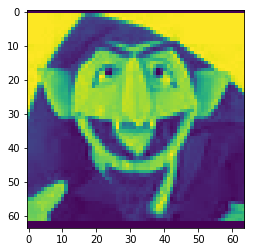

In [49]:
plt.imshow(X[1][0])

In [50]:
X_train, y_train, X_test, y_test = split_dataset(X, y)

In [51]:
class_labels

{0: 'count',
 1: 'rowlf_the_dog',
 2: 'bert',
 3: 'gonzo',
 4: 'cookie_monster',
 5: 'big_bird',
 6: 'oscar_the_grouch',
 7: 'fozzie_bear',
 8: 'beaker',
 9: 'scooter',
 10: 'elmo',
 11: 'rizzo_the_rat',
 12: 'ernie',
 13: 'miss_piggy',
 14: 'animal',
 15: 'kermit_the_frog',
 16: 'swedish_chef',
 17: 'grover'}

In [52]:
X_train.shape

(508, 3, 64, 64)

In [53]:
y_train.shape

(508,)

# ConvNet Architecture and Training

Now we can define our ConvNet architecture and then train it using a GPU/CPU (I have a very cheap GPU, but it helps a lot):

In [68]:
layers0 = [
    # Input layer.
    (layers.InputLayer,     {'shape': (None, 3, 64, 64)}),

    # Cut the image size down, just to see if we can get better accuracy with more convolution layers.
    #(layers.MaxPool2DLayer, {'pool_size': 2}),
    
    # First stage of convolution.
    (layers.Conv2DLayer,    {'num_filters': 64, 'filter_size': 3, 'pad': 'same'}),
    (layers.Conv2DLayer,    {'num_filters': 64, 'filter_size': 3, 'pad': 'same'}),
    (layers.Conv2DLayer,    {'num_filters': 64, 'filter_size': 3, 'pad': 'same'}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),
    
    # Second stage of convolution.
    (layers.Conv2DLayer,    {'num_filters': 32, 'filter_size': 3, 'pad': 'same'}),
    (layers.Conv2DLayer,    {'num_filters': 32, 'filter_size': 3, 'pad': 'same'}),
    (layers.Conv2DLayer,    {'num_filters': 32, 'filter_size': 3, 'pad': 'same'}),
    (layers.Conv2DLayer,    {'num_filters': 32, 'filter_size': 3, 'pad': 'same'}),

    # Two dense layers with a dropout.
    (layers.DenseLayer,     {'num_units': 256}),
    (layers.DropoutLayer,   {}),
    (layers.DenseLayer,     {'num_units': 256}),

    # The output layer.
    (layers.DenseLayer,     {'num_units': len(class_labels), 'nonlinearity': softmax}),   
    ]
    

In [55]:
def train_network(layers, rounds, X, y):
    net = NeuralNet(
        layers = layers,
    
        # Optimization method params
        update               = adam,
        update_learning_rate = 0.0002,
        objective_l2         = 0.0025,

        # Training configuration.
        max_epochs = rounds,
        verbose    = 2,
        )

    # Train the network
    nn = net.fit(X, y)
    
    return nn

# Neural Network with 8581138 learnable parameters

## Layer information

name        size        total    cap.Y    cap.X    cov.Y    cov.X
----------  --------  -------  -------  -------  -------  -------
input0      3x64x64     12288   100.00   100.00   100.00   100.00
conv2d1     64x64x64   262144   100.00   100.00     4.69     4.69
conv2d2     64x64x64   262144    60.00    60.00     7.81     7.81
conv2d3     64x64x64   262144    42.86    42.86    10.94    10.94
maxpool2d4  64x32x32    65536    42.86    42.86    10.94    10.94
conv2d5     32x32x32    32768    54.55    54.55    17.19    17.19
conv2d6     32x32x32    32768    40.00    40.00    23.44    23.44
conv2d7     32x32x32    32768    31.58    31.58    29.69    29.69
conv2d8     32x32x32    32768    26.09    26.09    35.94    35.94
dense9      256           256   100.00   100.00   100.00   100.00
dropout10   256           256   100.00   100.00   100.00   100.00
dense11     256           256   100.00   100.00   100.00   100.00
de

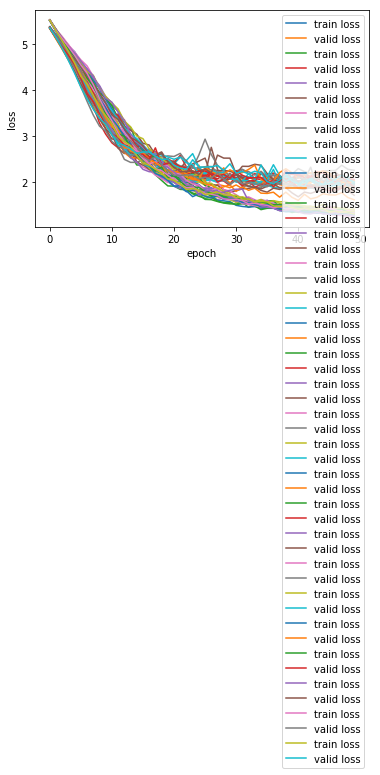

In [82]:
num_networks = 25     # The number of networks to try training
train_epochs = 50    # The number of epochs per network

weights = []
scores  = []

for i in range(num_networks):
    net = train_network(layers0, train_epochs, X_train, y_train)
    weights.append(lasagne.layers.get_all_param_values(net.layers_[-1]))
    scores.append(net.score(X_test, y_test))
    
    plot_loss(net)
    
    del net
    gc.collect()

In [90]:
for i in range(len(scores)):
    print i, ": ", scores[i]

0 :  0.866141732283
1 :  0.834645669291
2 :  0.866141732283
3 :  0.842519685039
4 :  0.811023622047
5 :  0.874015748031
6 :  0.874015748031
7 :  0.866141732283
8 :  0.826771653543
9 :  0.866141732283
10 :  0.88188976378
11 :  0.795275590551
12 :  0.905511811024
13 :  0.858267716535
14 :  0.905511811024
15 :  0.874015748031
16 :  0.913385826772
17 :  0.811023622047
18 :  0.811023622047
19 :  0.795275590551
20 :  0.889763779528
21 :  0.842519685039
22 :  0.92125984252
23 :  0.850393700787
24 :  0.826771653543


In [91]:
max_score = max(scores)
max_index = scores.index(max_score)

print "Max score is %0.3f at %d" % (max_score, max_index)

Max score is 0.921 at 22


# Construct a net out of our most efficient model.

In [92]:
del best_net
gc.collect()

280466

In [93]:
# Now construct the NeuralNet object.
best_net = NeuralNet(
        layers = layers0,
    
        # optimization method params
        update=adam,
        update_learning_rate=0.0002,
    
        objective_l2=0.0025,

        max_epochs=50,
        verbose=2,
)
    
best_net.initialize()
lasagne.layers.set_all_param_values(best_net.layers_[-1], weights[max_index])

# Examine the architecture of the neural network.

We're looking for capacity to never drop below 1/6th (16.7%), and coverage to not go over 100%.

In [94]:
layer_info(best_net)

# Neural Network with 8581138 learnable parameters

## Layer information

name        size        total    cap.Y    cap.X    cov.Y    cov.X
----------  --------  -------  -------  -------  -------  -------
input0      3x64x64     12288   100.00   100.00   100.00   100.00
conv2d1     64x64x64   262144   100.00   100.00     4.69     4.69
conv2d2     64x64x64   262144    60.00    60.00     7.81     7.81
conv2d3     64x64x64   262144    42.86    42.86    10.94    10.94
maxpool2d4  64x32x32    65536    42.86    42.86    10.94    10.94
conv2d5     32x32x32    32768    54.55    54.55    17.19    17.19
conv2d6     32x32x32    32768    40.00    40.00    23.44    23.44
conv2d7     32x32x32    32768    31.58    31.58    29.69    29.69
conv2d8     32x32x32    32768    26.09    26.09    35.94    35.94
dense9      256           256   100.00   100.00   100.00   100.00
dropout10   256           256   100.00   100.00   100.00   100.00
dense11     256           256   100.00   100.00   100.00   100.00
de

# Prediction and Confusion Matrix

Now we can use the model to predict the entire testing dataset:



In [95]:
preds = best_net.predict(X_test)

And we can also plot a confusion matrix to check the performance of the neural network classification:

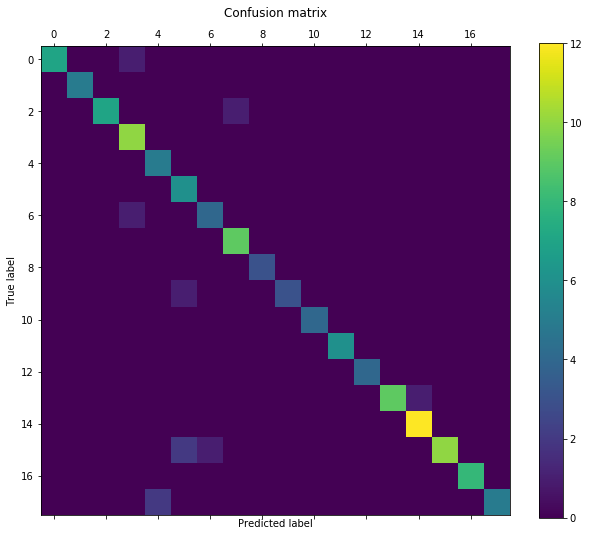

In [96]:
cm = confusion_matrix(y_test, preds)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
fig = plt.gcf()
fig.set_size_inches(10.5, 8.5)
plt.show()

# Filters Visualization

We can also visualize the 32 filters from the first convolutional layer:

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

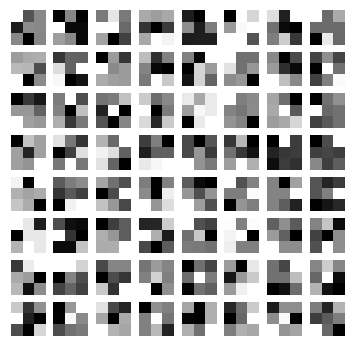

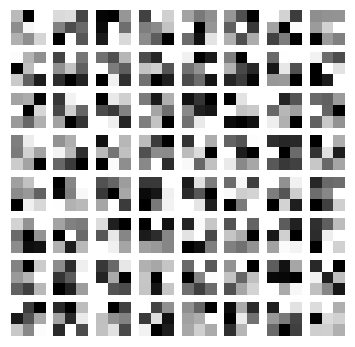

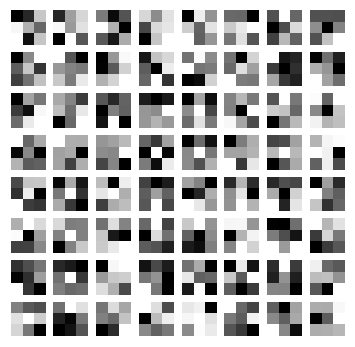

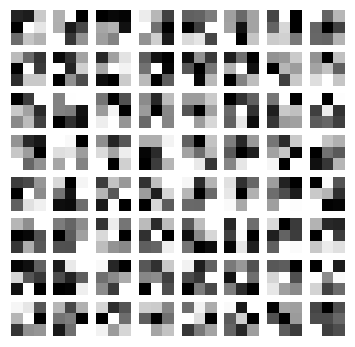

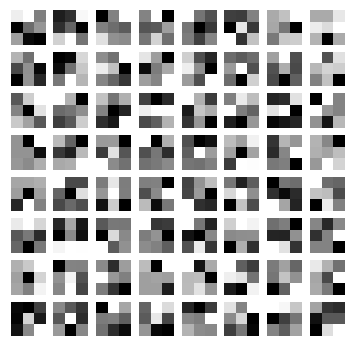

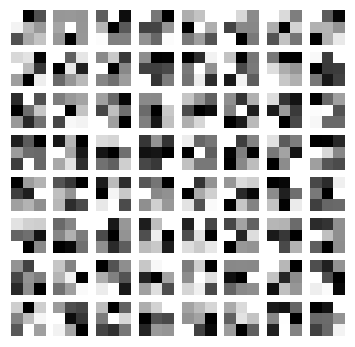

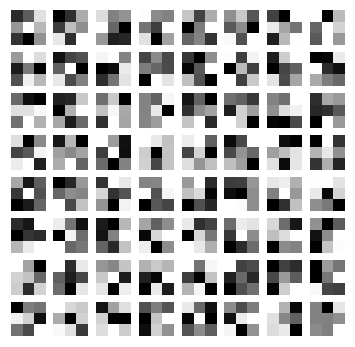

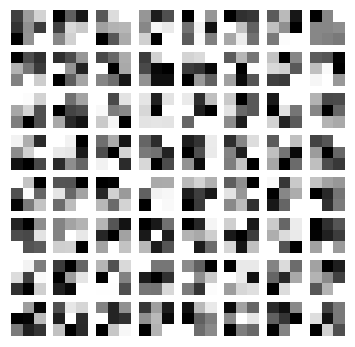

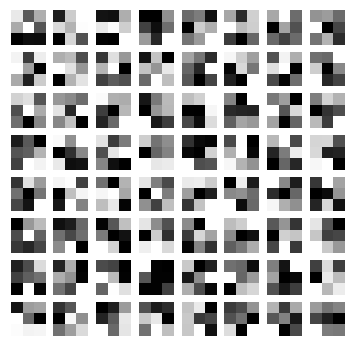

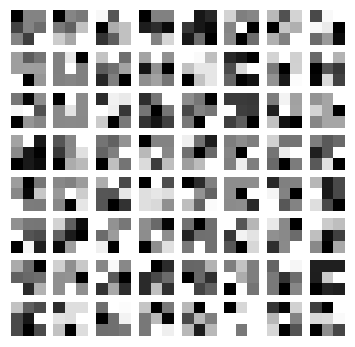

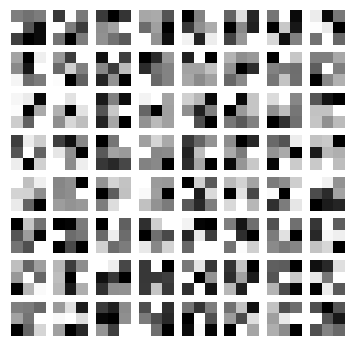

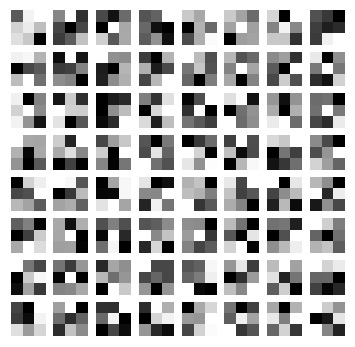

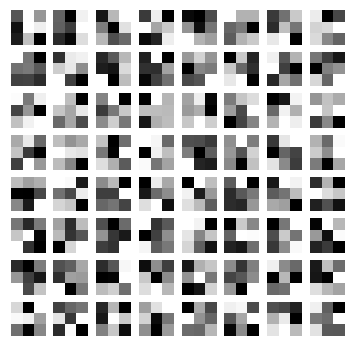

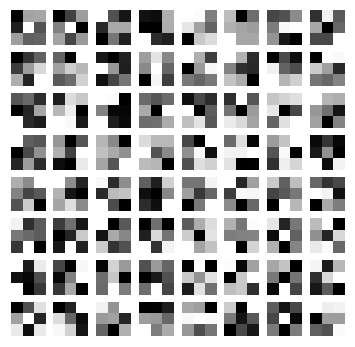

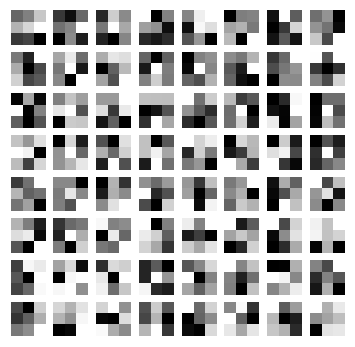

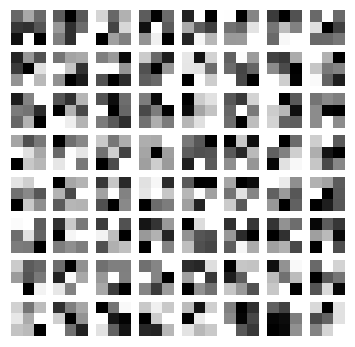

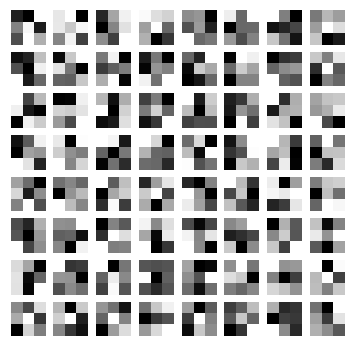

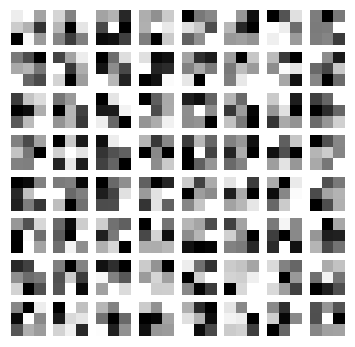

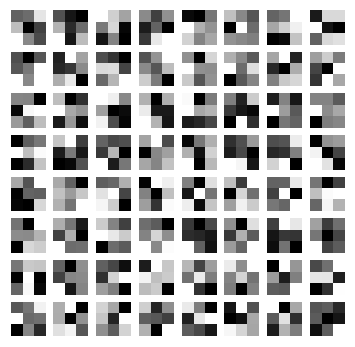

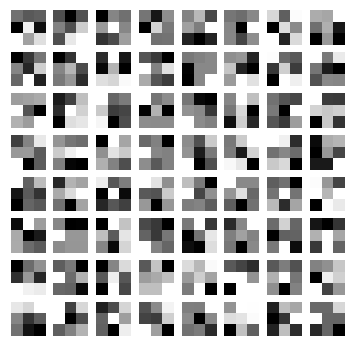

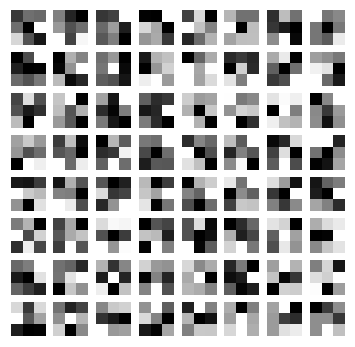

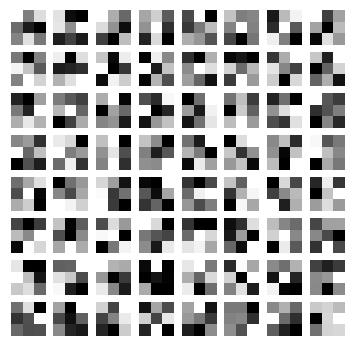

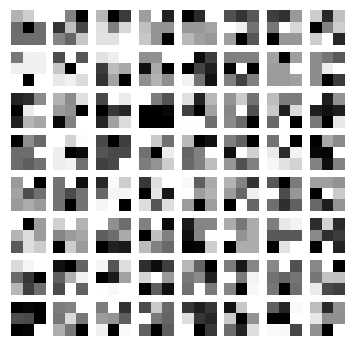

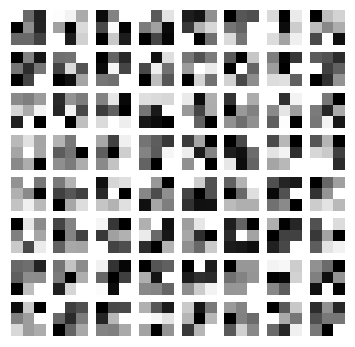

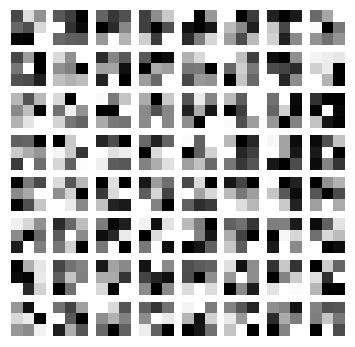

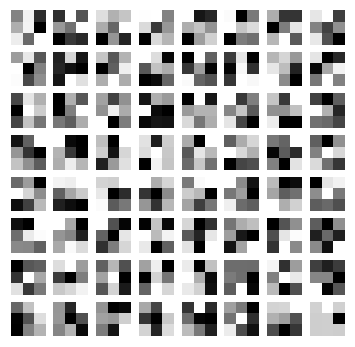

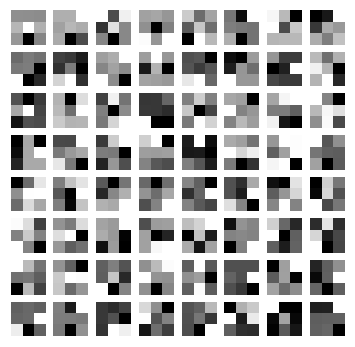

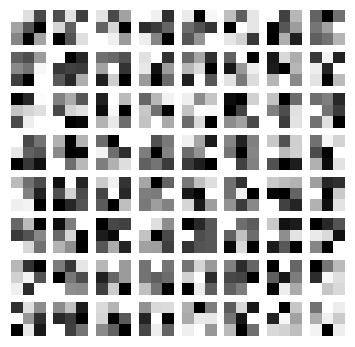

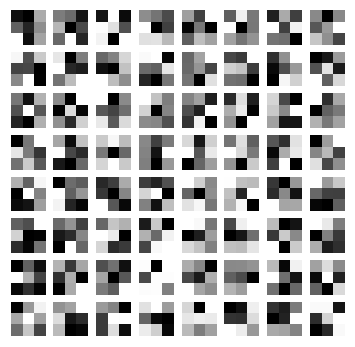

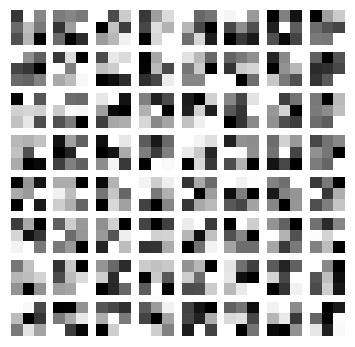

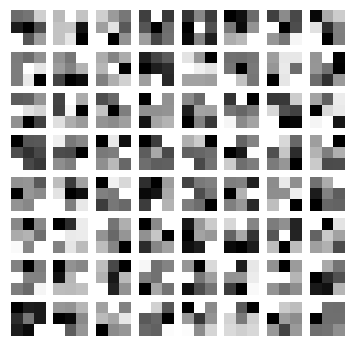

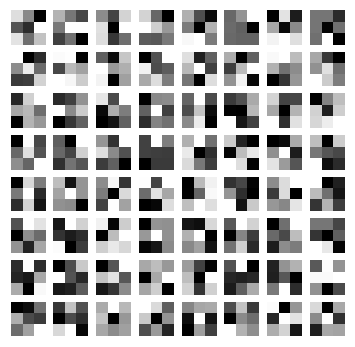

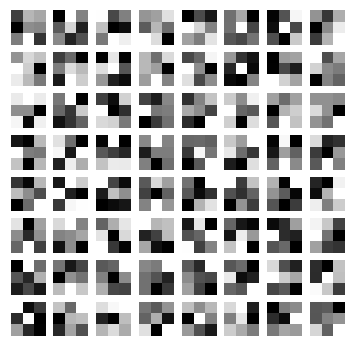

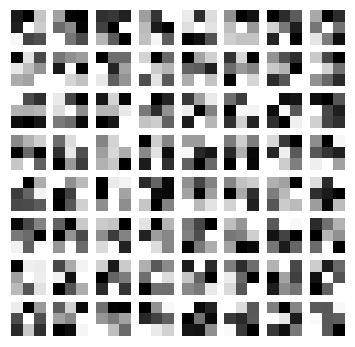

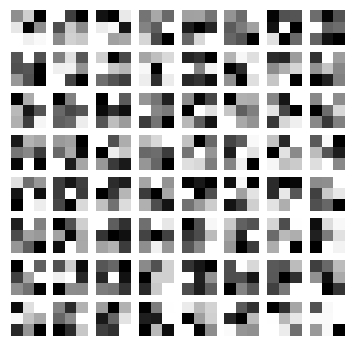

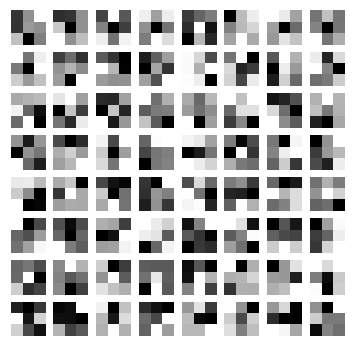

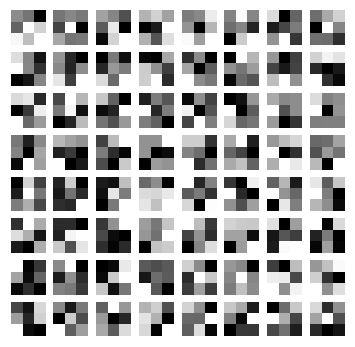

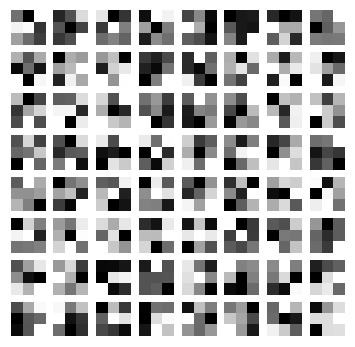

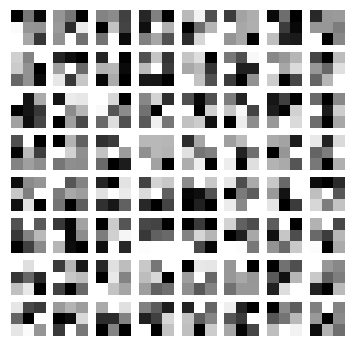

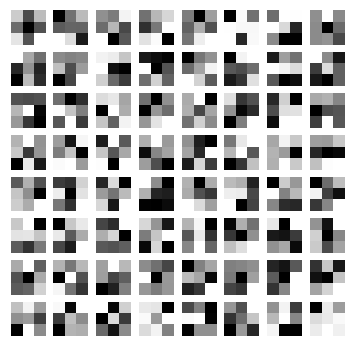

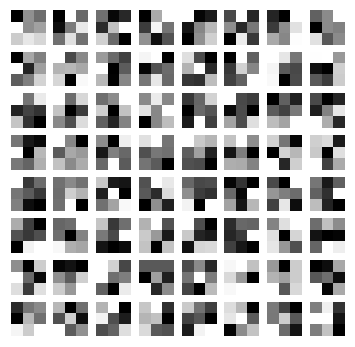

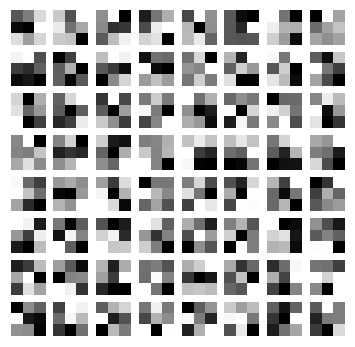

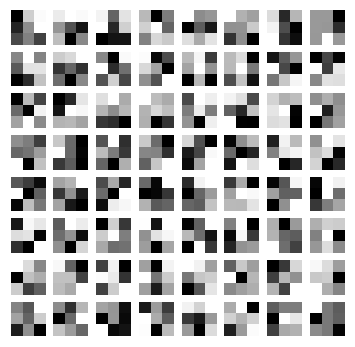

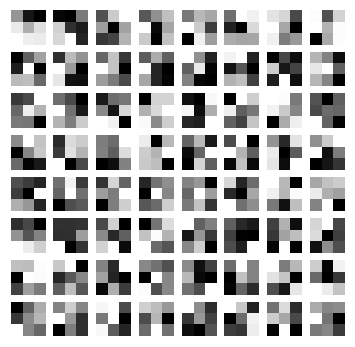

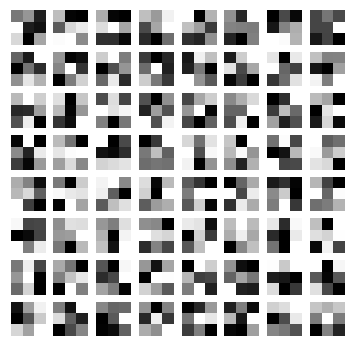

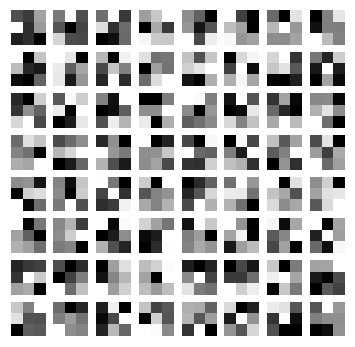

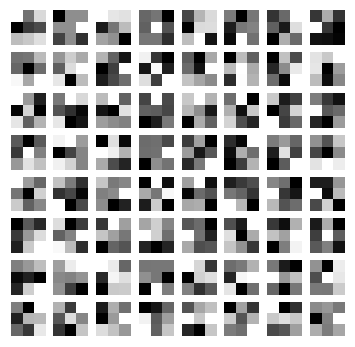

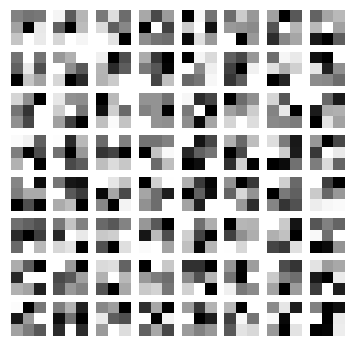

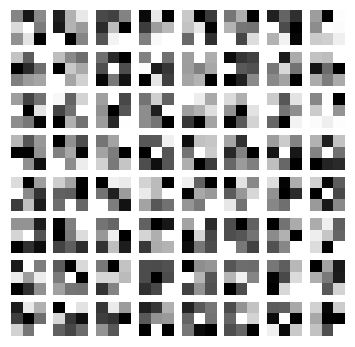

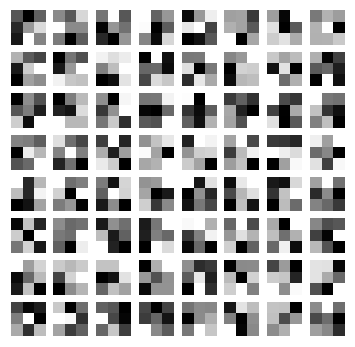

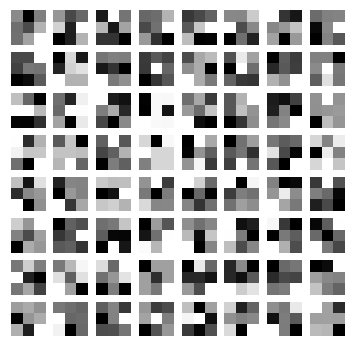

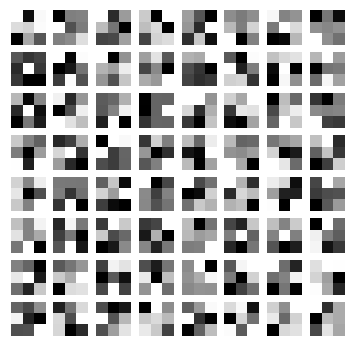

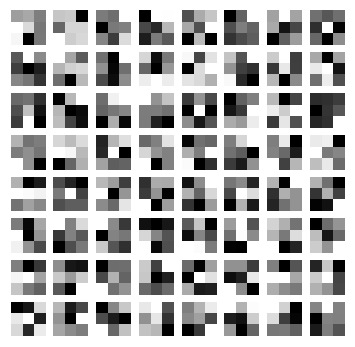

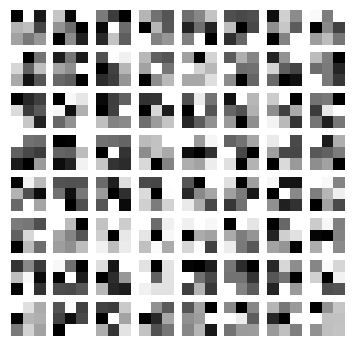

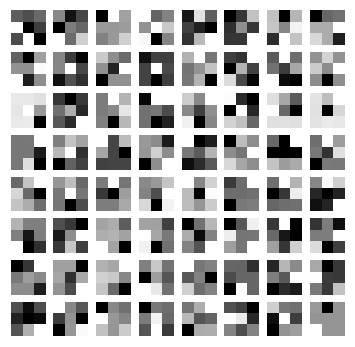

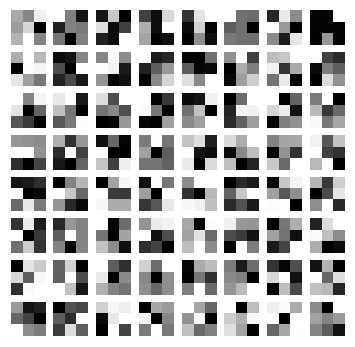

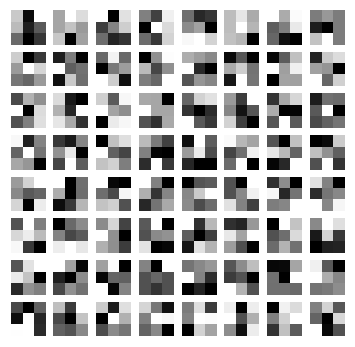

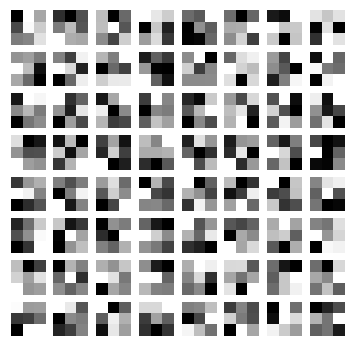

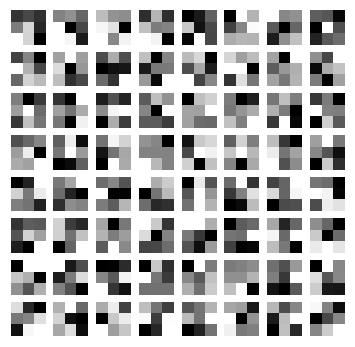

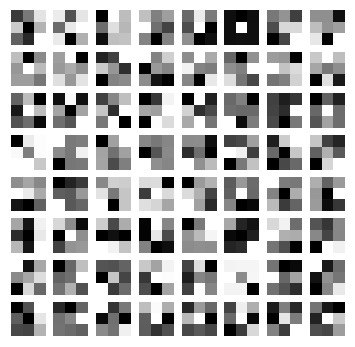

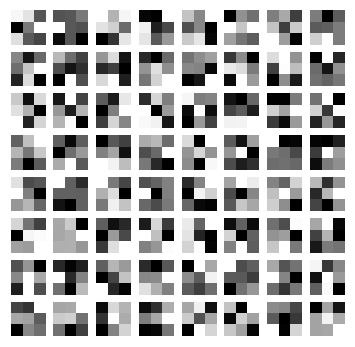

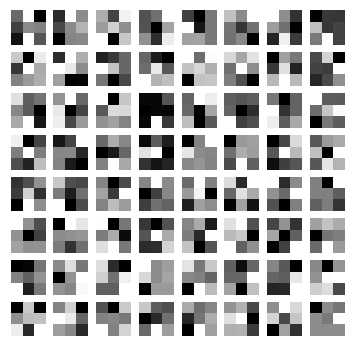

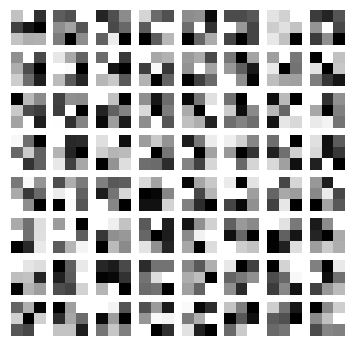

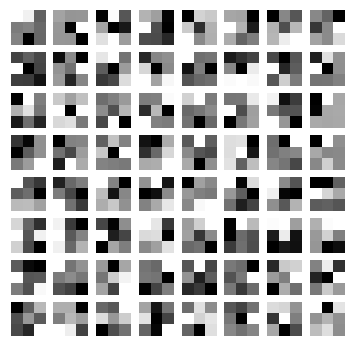

In [97]:
visualize.plot_conv_weights(best_net.layers_['conv2d2'])

# Theano layer functions and Feature Extraction

Now it is time to create theano-compiled functions that will feed-forward the input data into the architecture up to the layer you’re interested. I’m going to get the functions for the output layer and also for the dense layer before the output layer:

In [13]:
dense_layer = layers.get_output(net1.layers_['dense1'], deterministic=True)
output_layer = layers.get_output(net1.layers_['output'], deterministic=True)
input_var = net1.layers_['input'].input_var
f_output = theano.function([input_var], output_layer)
f_dense = theano.function([input_var], dense_layer)

As you can see, we have now two theano functions called f_output and f_dense (for the output and dense layers). Please note that in order to get the layers here we are using a extra parameter called “deterministic“, this is to avoid the dropout layers affecting our feed-forward pass.

We can now convert an example instance to the input format and then feed it into the theano function for the output layer:

In [14]:
instance = X_test[0][None, :, :]
%timeit -n 500 f_output(instance)

500 loops, best of 3: 20 ms per loop


We can also plot the output layer activations for the instance:

<Container object of 28 artists>

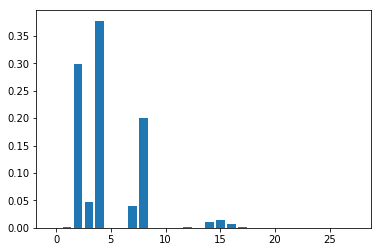

In [15]:
pred = f_output(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())

<Container object of 256 artists>

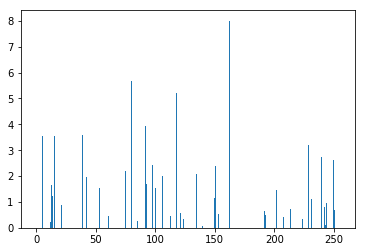

In [16]:
pred = f_dense(instance)
N = pred.shape[1]
plt.bar(range(N), pred.ravel())

You can now use the output of the these 256 activations as features on a linear classifier like Logistic Regression or SVM.

# Now let's save the model.

In [98]:
def save_neural_network(neural_network, base_name="muppets-theano"):
    
    # Save the layer configuration.
    f = open('%s.model.pickle' % base_name, 'wb')
    pickle.dump(neural_network.layers, f, pickle.HIGHEST_PROTOCOL)
    f.close()
    
    # Save the learned weights.
    all_param_values = lasagne.layers.get_all_param_values(neural_network.layers_[-1])
    f = open ('%s.params.pickle' % base_name, 'wb')
    pickle.dump(all_param_values, f, pickle.HIGHEST_PROTOCOL)
    f.close()

In [99]:
save_neural_network(best_net, "muppets-theano-face-bestof50")

# Load it back in.

In [43]:
def load_neural_network(model_file, param_file):
    # Load the layer configuration.
    f = open(model_file, 'r')
    layers = pickle.load(f)
    f.close()
    
    # Load the weights.
    f = open(param_file, 'r')
    param_values = pickle.load(f)
    f.close()
    
    # Now construct the NeuralNet object.
    neural_net = NeuralNet(
        layers = layers,
    
        # optimization method params
        update=adam,
        update_learning_rate=0.0002,
    
        objective_l2=0.0025,

        max_epochs=50,
        verbose=1,
    )
    
    neural_net.initialize()
    lasagne.layers.set_all_param_values(neural_net.layers_[-1], param_values)
    
    return neural_net

In [46]:
unpickled_net = load_neural_network('muppets-theano-bestof50.model.pickle', 'muppets-theano-bestof50.params.pickle')
preds = unpickled_net.predict(X_test)

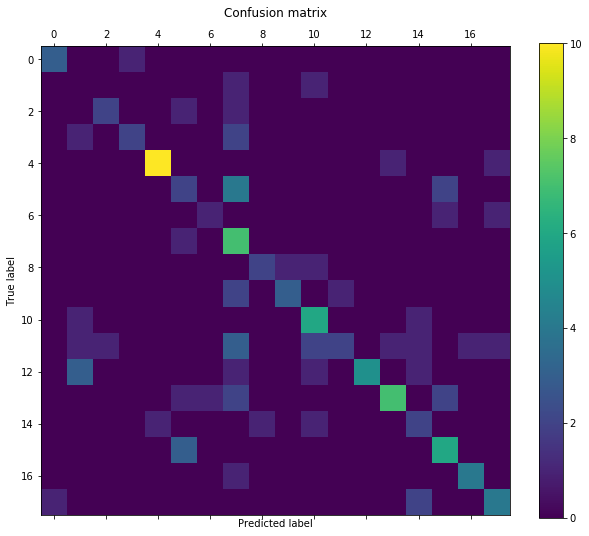

In [47]:
cm = confusion_matrix(y_test, preds)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
fig = plt.gcf()
fig.set_size_inches(10.5, 8.5)
plt.show()

# Scratch area.

In [89]:
lasagne.layers.get_all_param_values(net1.layers_[-1])

[array([[[[  9.39350948e-02,   1.97814982e-02,   8.33949912e-03],
          [ -1.06917001e-01,   5.73661663e-02,   5.26966676e-02],
          [ -6.98553622e-02,  -6.99025244e-02,  -2.44765989e-02]],
 
         [[ -1.01477906e-01,  -3.44158709e-02,  -7.87952356e-03],
          [  9.08585712e-02,   1.53867644e-03,   1.01032905e-01],
          [  6.41664192e-02,   2.10522092e-03,  -8.09710324e-02]],
 
         [[ -4.78201397e-02,  -6.21216954e-04,  -3.88260297e-02],
          [ -3.56477462e-02,   4.55134921e-02,  -1.04661524e-01],
          [ -4.45074476e-02,   1.14895254e-02,  -2.46580038e-02]]],
 
 
        [[[ -1.17359951e-01,  -1.24242313e-01,  -4.48756330e-02],
          [  1.07583195e-01,   9.33326259e-02,  -4.83082002e-03],
          [  7.81019405e-02,  -6.01462461e-02,  -7.60708675e-02]],
 
         [[  6.10128627e-04,   1.15330881e-02,   7.15533718e-02],
          [ -1.34071824e-03,  -9.32946801e-02,  -5.90519384e-02],
          [  6.49811514e-03,  -6.90878853e-02,   7.11376518e-